In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

In [2]:
import sys
sys.path.append('../')
from src.dataset import read_folder
from src.visualization import plot_img, plot_corr, plot_hist_with_component

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
# define Path
PATH = '../LaPa/examples'
# load few examples
images = read_folder(PATH, n = 10, labels = 'labels')

In [5]:
# plot image with diffrent color palette

def plot_diffrent_color_palette(img_BGR, with_labels = False, labels = None):
    """plot image using a few kind of color palette"""
    
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_RGB2HSV)
    img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    
    # definie subplots space
    if with_labels:
        f, ax = plt.subplots(1,5, figsize=(15,5))
        plot_img(labels*100, ax = ax[0], title = "Labels")
    else:
        f, ax = plt.subplots(1,4, figsize=(15,5))

    plot_img(img_BGR, ax = ax[0 + with_labels], title = "BGR")
    plot_img(img_RGB, ax = ax[1 + with_labels], title = "RGB")
    plot_img(img_HSV, ax = ax[2 + with_labels], title = "HSV")
    plot_img(img_YCrCb, ax = ax[3 + with_labels], title = "YCrCb")


In [6]:
# choose images to example process
example_img = list(images.keys())[3]

Let's look at the different color palettes depending on the color of the skin and the exposure and quality of the photo.

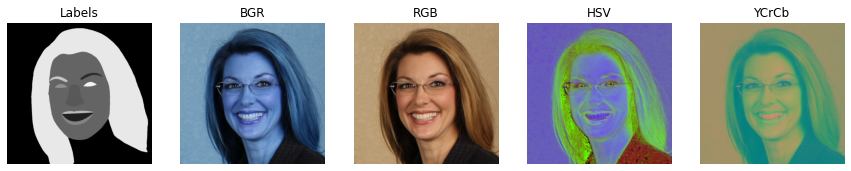

In [7]:
img_BGR = images[example_img]['img']
img_labels = images[example_img]['labels']
plot_diffrent_color_palette(img_BGR,  with_labels = True, labels = img_labels)

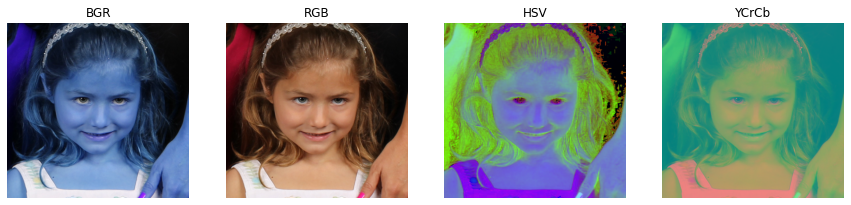

In [13]:
img_BGR = images[list(images.keys())[5]]['img']
plot_diffrent_color_palette(img_BGR)

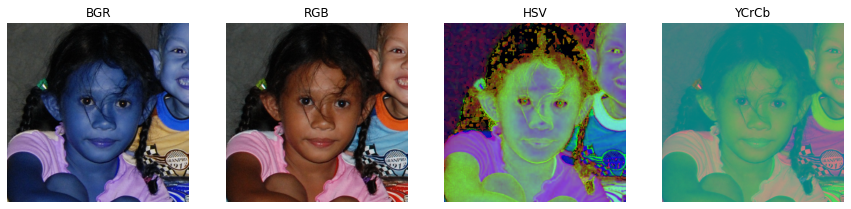

In [14]:
img_BGR = images[list(images.keys())[7]]['img']
plot_diffrent_color_palette(img_BGR)

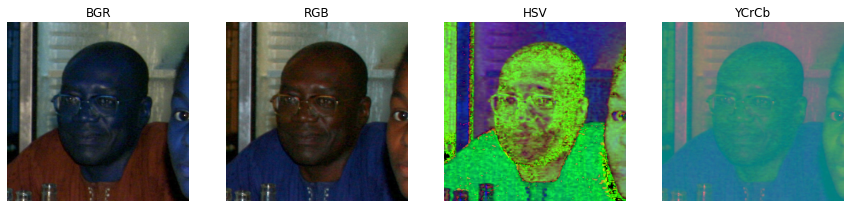

In [15]:
img_BGR = images[list(images.keys())[8]]['img']
plot_diffrent_color_palette(img_BGR)

**Check color palette components**

As we will see later, a very important element in our analysis will be the analysis of the color components of individual pallets.

The component histogram allows us to see the real dependencies and, above all, the color ranges. These range can be "pulled out" by a very simple thresholding.

In [8]:
def plot_color_palette_components(img, title, axes):
    """plot each color component in a separate window and component histogram"""
    for i in range(3):
        component = img[:,:,i]
        plot_img(component, ax = axes[i], title = f'{title}[{i}]')
        plot_hist_with_component(component, axes[-1], f'{title}[{i}]' )
    axes[-1].legend()
    plt.tight_layout()

In [17]:
def plot_diffrent_color_palette_with_components(img_BGR):
    """plot image using a few kind of color palette, each component plot in a separate window"""
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_RGB2HSV)
    img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)

    plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(1,5,1)
    plot_img(img_RGB, ax = ax1, title = "RGB")
    
    # definie subplots space for HSV
    axes_hsv = []
    for i in range(4):
        ax = plt.subplot(2,5,i+2)
        axes_hsv.append(ax)

    # plot HSV components
    plot_color_palette_components(img_HSV, 'HSV', axes_hsv)

    # definie subplots space for YCrCb
    axes_YCrCb = []
    for i in range(4):
        ax = plt.subplot(2,5,i+7)
        axes_YCrCb.append(ax)

    # plot YCrCb components
    plot_color_palette_components(img_YCrCb, 'YCrCb', axes_YCrCb)

Now let's compare two pictures of girls, focusing on the color components. In this case, it would be difficult to choose such parameters to be able to designate girls' faces using RGB.

Looking only at the histograms, we can see that we are not able to set such a threshold for the components:  Hsv[2], YCrCb0] to be able to get a good skin extension effect. Moreover, the range of the face skin in the two pictures are different. We can also see that the light have huge influence on result.

The good news is that despite the different shades / ranges, we can clearly see the separation of the skin from the rest of the image, for example on YCrCb[2] is possible (but maybe not perfect). In the first picture, light strands of hair that match the color of the skin may be problematic.

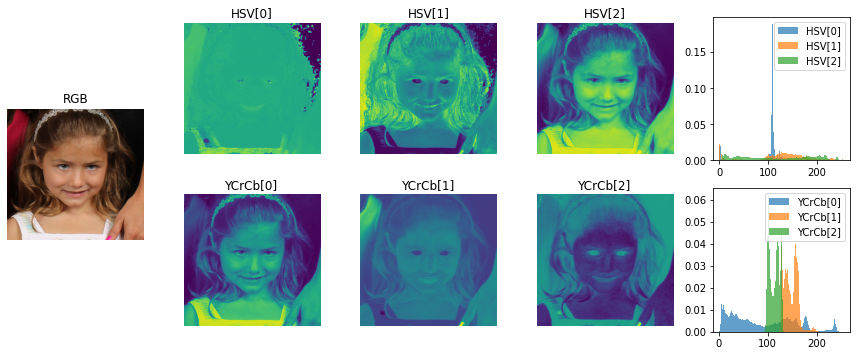

In [18]:
img_BGR = images[list(images.keys())[5]]['img']
plot_diffrent_color_palette_with_components(img_BGR)

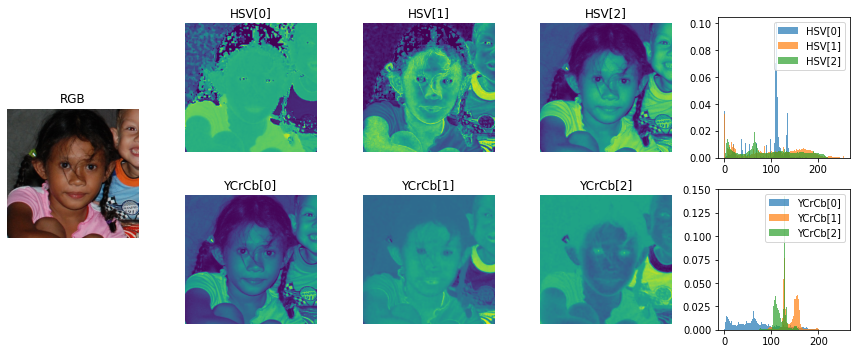

In [19]:
img_BGR = images[list(images.keys())[7]]['img']
plot_diffrent_color_palette_with_components(img_BGR)

Let us consider one more example. The image below has a lot of hype, not good quality, but some very important aspects worth mentioning. Firstly, when analyzing images using classical methods (focusing on e.g. thresholds, colors), it is very difficult to build a general, general algorithm that fits all conditions (image quality, lighting, colors). Second, while one rule might work great for one image, it might not work for another. In the picture below, a very good and clear skin is visible in the combination of HSV[0], HSV[1] and YCrCb[2]. 

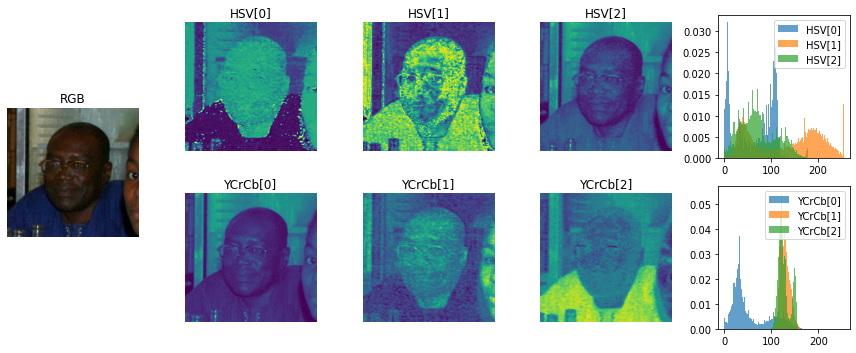

In [20]:
img_BGR = images[list(images.keys())[8]]['img']
plot_diffrent_color_palette_with_components(img_BGR)

**First naive Tresholding**

Let's choose one exemplary component, e.g. YCrCb[2] and try to choose such a range to be able to determine the skin in the image

In [91]:
def plot_treshold_hist(img_RGB, labels_skin_face, component, treshold_range, ax, ax_i, legend):
    plot_hist_with_component(component, ax[ax_i], legend )
    if type(treshold_range[0]) is int:
        ax[ax_i].axvline(x=treshold_range[0], color = 'r')
        ax[ax_i].axvline(x=treshold_range[1], color = 'b')
    else:
        no_channels = len(treshold_range[0])
        for i in range(no_channels):
            ax[ax_i].axvline(x=treshold_range[0][i], color = 'r')
            ax[ax_i].axvline(x=treshold_range[1][i], color = 'b')
    ax[ax_i].set_title("Histogram with treshold")
    mask_created_via_treshold = (cv2.inRange(component, * treshold_range)/255).astype(int)
    plot_img(mask_created_via_treshold, ax = ax[ax_i + 1], title = f"binary \n result of using \n treshold {treshold_range}")
    
    plot_img(labels_skin_face*100, ax = ax[ax_i + 2])
    plot_img(mask_created_via_treshold, ax = ax[ax_i + 2],
             alpha = 0.5, 
             title = f"comparison between face skin and \n created mask \n using treshold {treshold_range}")
    
    plot_img(np.dstack([mask_created_via_treshold]*3) * img_RGB, title = f"result \n of using treshold {treshold_range}", ax = ax[ax_i + 3])

In [92]:
def simple_tresholding(images, example_img, treshold_ranges):
    
    img_BGR = images[example_img]['img']
    img_labels = images[example_img]['labels']
    labels_skin_face = img_labels==1
    
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    
    
    f, axs = plt.subplots(4,4, figsize=(15,15))
    axs = axs.flatten()
    plot_img(img_RGB, ax = axs[0], title = "RGB")
    plot_img(img_labels*100, ax = axs[1], title = "labels")
    component = img_YCrCb[:,:,2]
    plot_img(component, ax = axs[2], title = "YCrCb[2]")
    plot_hist_with_component(component, axs[3])

    j = 4
    for treshold in treshold_ranges:
        plot_treshold_hist(img_RGB, labels_skin_face, component, treshold, axs, j, f'YCrCb[2]')
        j = j + 4

    plt.tight_layout()

Now let's choose some `treshold_ranges`. Of course, they are selected from the first picture I discuss, but it doesn't matter, I just wanted to show you the principle of operation and the problems arising from this method.

In [93]:
# treshold_ranges is list of 3 example range of treshold. At the moment we focus on YCrCb[2]
treshold_ranges = [ [(int(np.min(component))), (110)] ,
    [(110), (124)],
    [(124), (int(np.max(component)))]
]

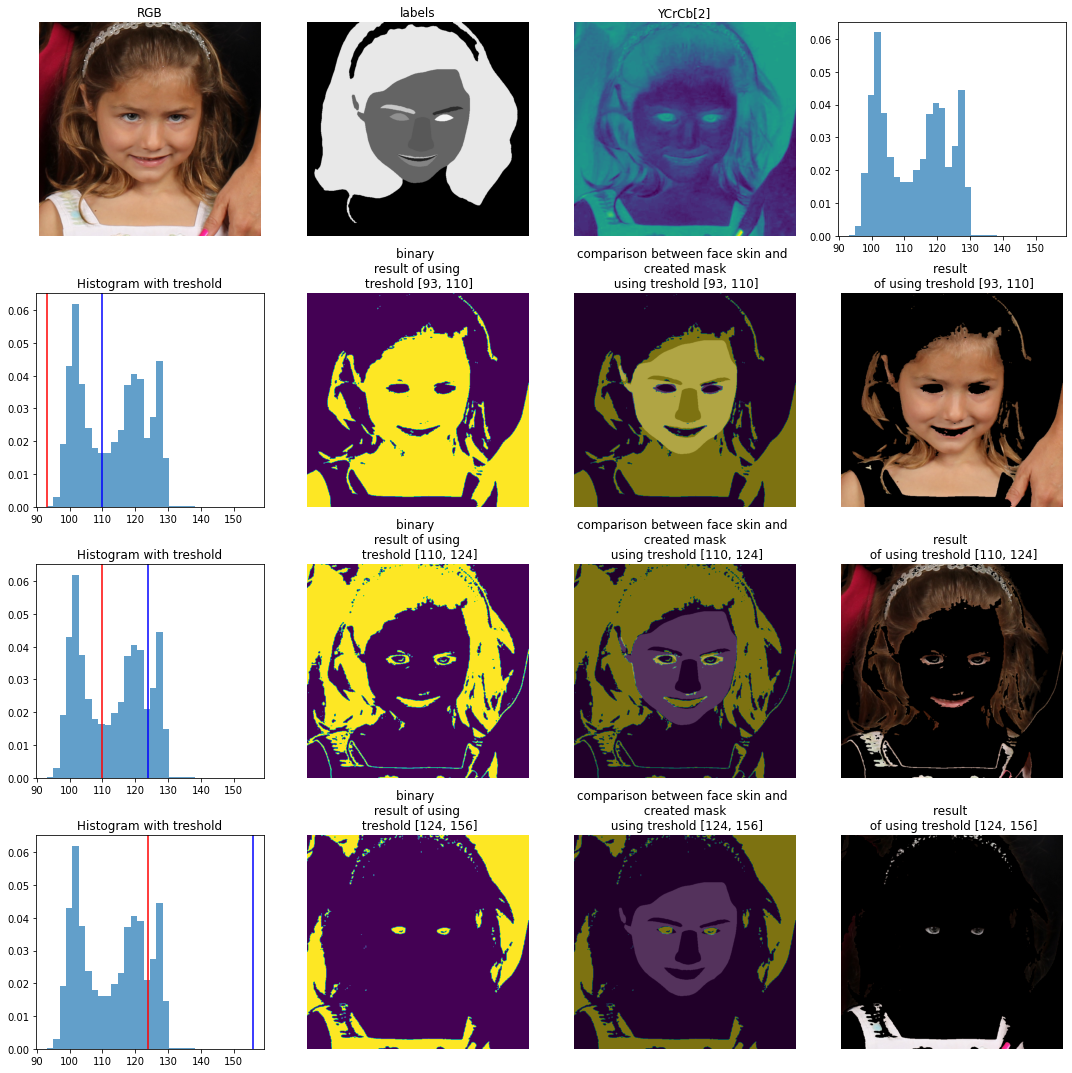

In [94]:
# choose one example image and check how treshold range affects on finall result
example_img = list(images.keys())[5]
simple_tresholding(images, example_img, treshold_ranges)

When we will use exactly the same range and apply to diffrent image effect can be 

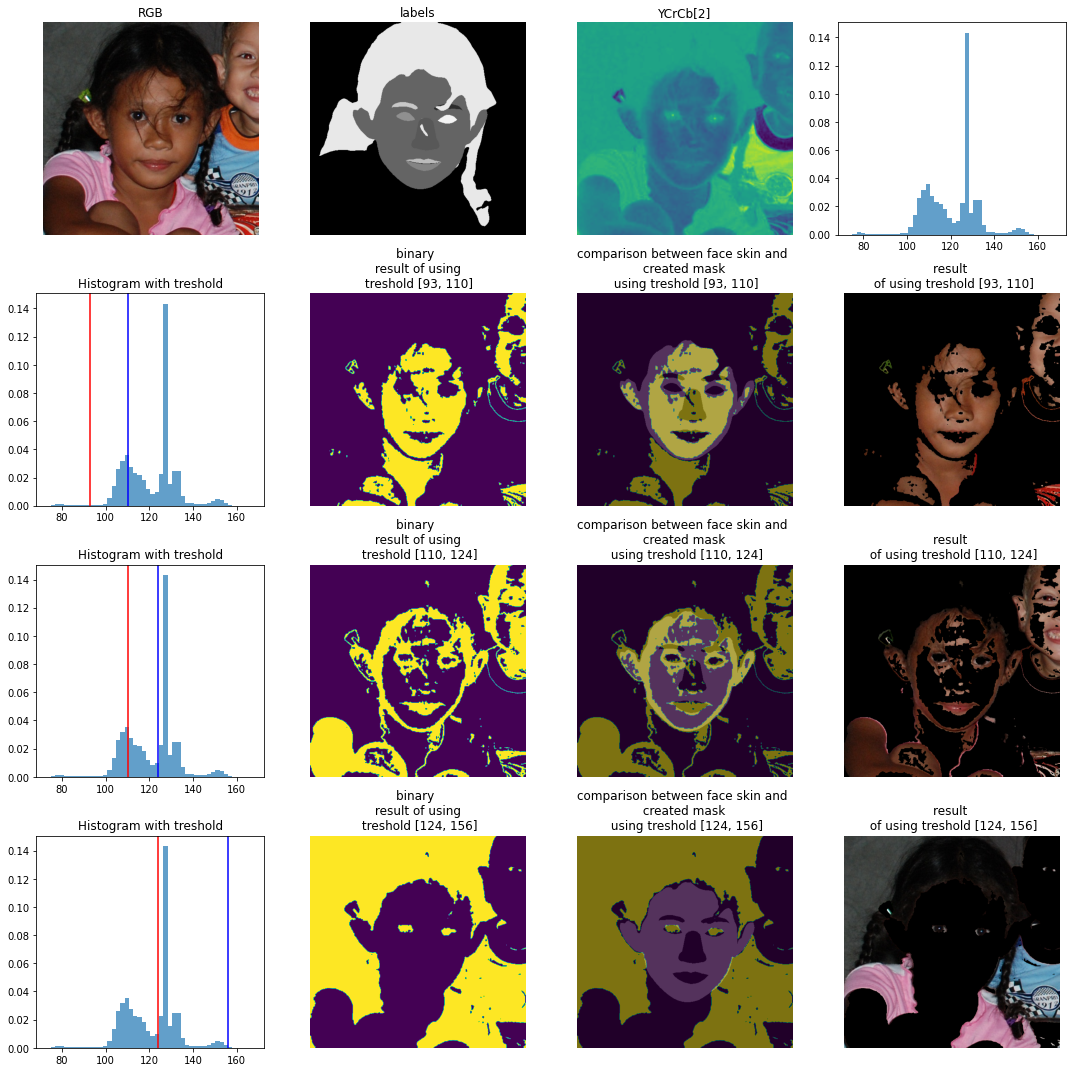

In [95]:
# choose one example image and check how treshold range affects on finall result can be diffrent
example_img = list(images.keys())[7]
simple_tresholding(images, example_img, treshold_ranges)

Let's check one more image

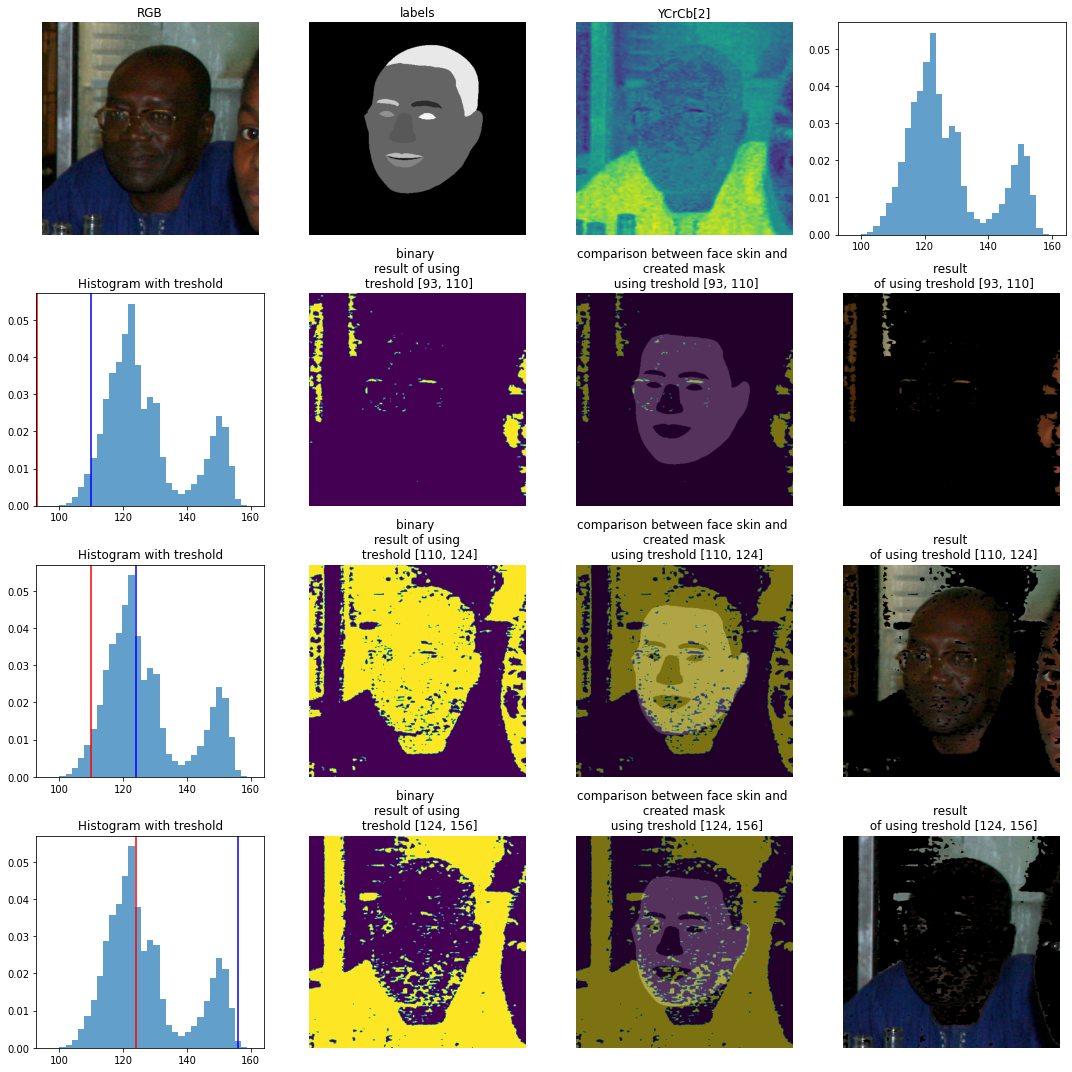

In [96]:
# choose one example image and check how treshold range affects on finall result can be diffrent
example_img = list(images.keys())[8]
simple_tresholding(images, example_img, treshold_ranges)

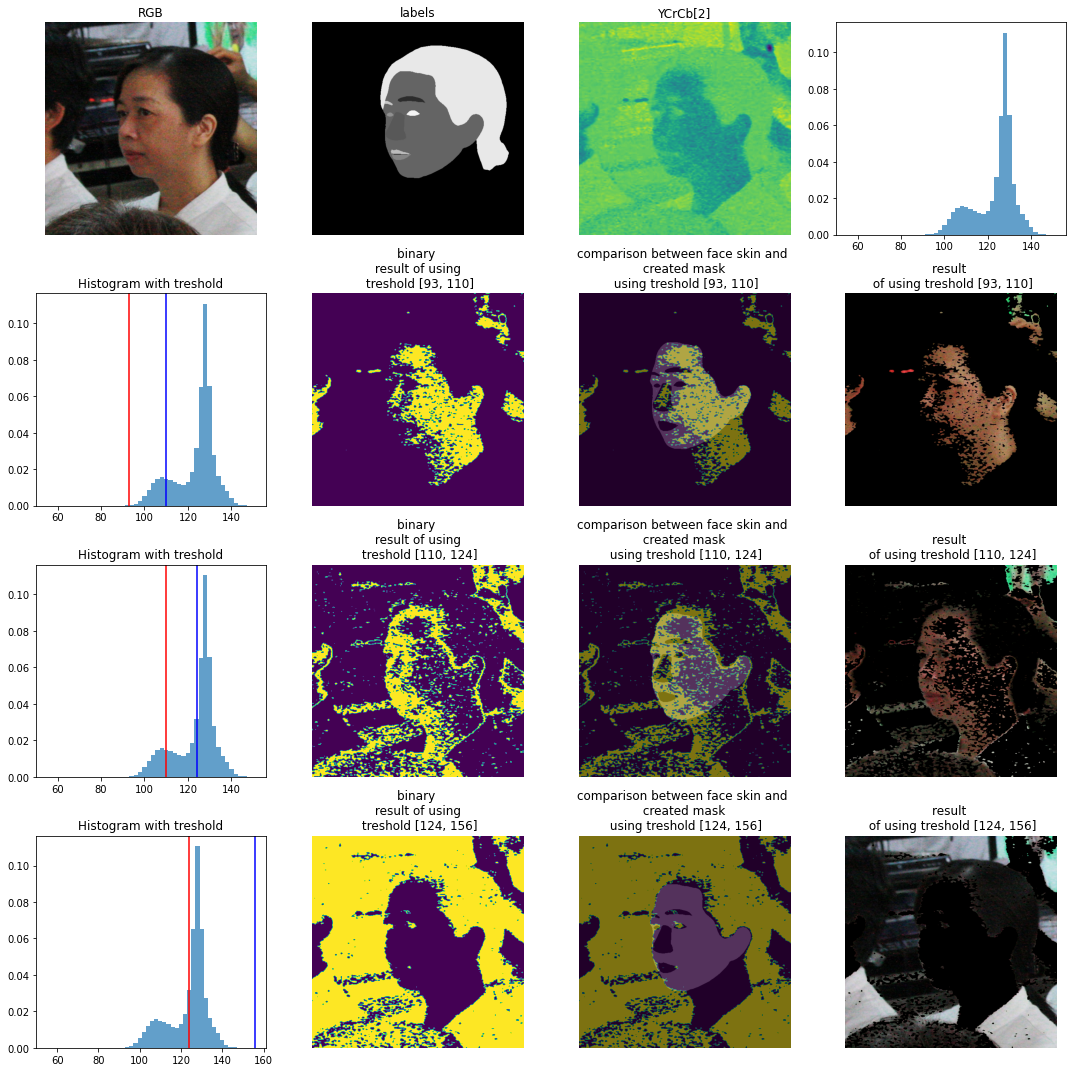

In [98]:
# choose one example image and check how treshold range affects on finall result can be diffrent
example_img = list(images.keys())[2]
simple_tresholding(images, example_img, treshold_ranges)

several conclusions:
- if we see more than one person in the picture, our database does not have labels for both people.
- matching one threshold is ineffective
- the histogram can have more than> 2 models. The face tends to be at lower values.

we have such a large database, let's check how the mean values ​​for the face are distributed for diffrent color palette.

In [21]:
# Firsly load few examples with labels(!)
images = read_folder(PATH, n = 10, labels = 'labels')

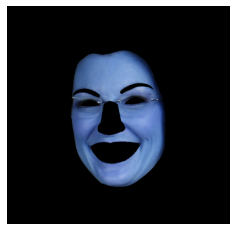

In [22]:
# choose images to example process
example_img = list(images.keys())[3]

# Next, separate a face region that can be interpreted as facial skin (labels = 1)
img = images[example_img]['img']
mask = images[example_img]['labels']
# plot intresing as region
skin_label = (mask==1)
region_img = skin_label * img
plot_img(region_img)

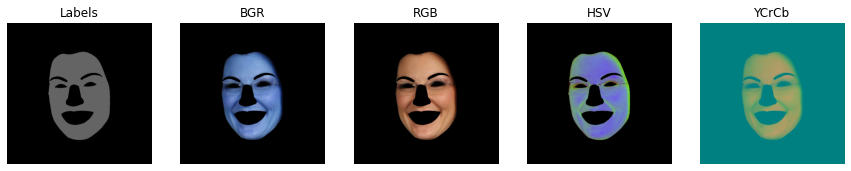

In [23]:
# We can use plot_diffrent_color_palette funtion to show diffrent palette colors
plot_diffrent_color_palette(region_img, True, skin_label)

In [27]:
# calcualte avg of region_img

In [28]:
mask_one_channel = mask[:,:,0] == 1
x = region_img[:,:,0][mask_one_channel].mean()
y = region_img[:,:,1][mask_one_channel].mean()
z = region_img[:,:,2][mask_one_channel].mean()

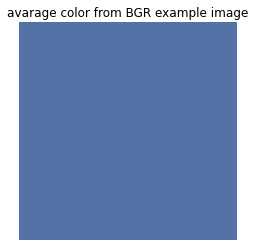

In [29]:
# create image just for new visualization 
avg_img = (x,y,z) * np.ones((2, 2,3))
plt.imshow(avg_img.astype(int))
plt.axis('off')
plt.title('avarage color from BGR example image')
plt.show()

In [30]:
def calculate_img_avg_by_channel(img_palette_color, mask_one_channel):
        x = img_palette_color[:,:,0][mask_one_channel].mean()
        y = img_palette_color[:,:,1][mask_one_channel].mean()
        z = img_palette_color[:,:,2][mask_one_channel].mean()
        return (x,y,z)

In [31]:
def change_img_to_color_palette(img_BGR):
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_BGR, cv2.COLOR_RGB2HSV)
    img_YCrCb = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2YCrCb)
    return img_RGB, img_HSV, img_YCrCb

In [32]:
def avg_color(img_BGR, mask_one_channel, plot = True):
    
    img_RGB, img_HSV, img_YCrCb = change_img_to_color_palette(img_BGR)
    
    _title = ['BGR', 'RGB', 'HSV', 'YCrCb']
    
    if plot:
        # definie subplots space
        f, ax = plt.subplots(1,4, figsize=(15,5))
    
    i=0
    _avgs = []
    for img_palette_color in [img_BGR, img_RGB, img_HSV, img_YCrCb]:
        x_y_z = calculate_img_avg_by_channel(img_palette_color, mask_one_channel)
        _avgs.append(x_y_z)
        
        if plot:
            avg_img = (x_y_z * np.ones((2, 2,3))).astype(int)
            plot_img(avg_img, ax = ax[i], title = _title[i])
        i+=1
    return _avgs

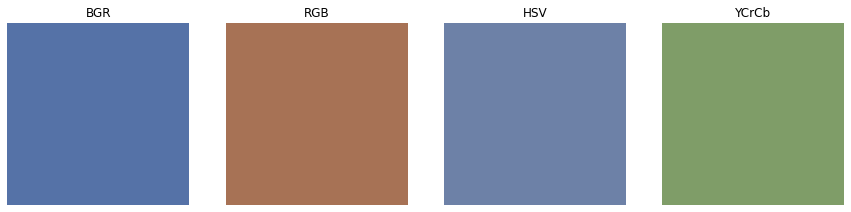

In [33]:
avgs = avg_color(region_img,  mask[:,:,0] == 1)

In [34]:
# Calculate avg using train dataset

In [35]:
# before this part let's download data from https://github.com/lucia123/lapa-dataset! 

In [36]:
# define Path 
PATH = '../LaPa/train'
# load few examples
images_train = read_folder(PATH, n = 1000, labels = 'labels')

In [37]:
images_train_imgs = list(images_train.keys())

train_avgs = np.zeros((3*4, len(images_train_imgs)))
i = 0
for example_img in images_train_imgs:
    img = images_train[example_img]['img']
    mask = images_train[example_img]['labels']
    mask_one_channel = mask[:,:,0] == 1
    avgs = avg_color(img, mask_one_channel, plot = False)
    train_avgs[:,i] = np.hstack(avgs)
    i += 1

In [38]:
avg_using_train_set = train_avgs.mean(axis=1)

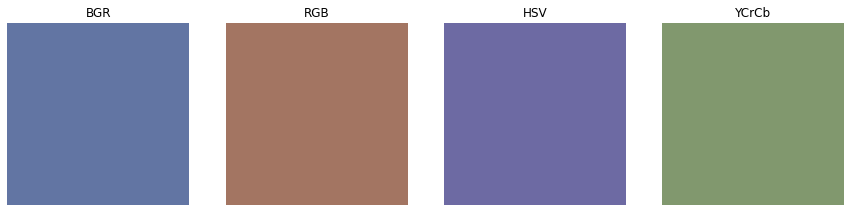

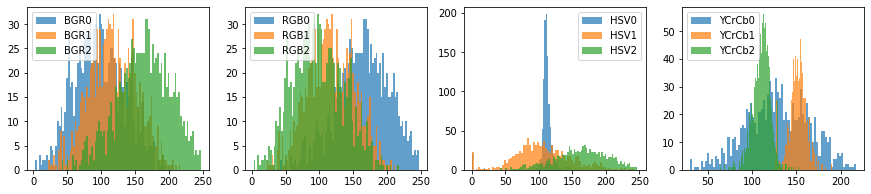

In [39]:
f, ax = plt.subplots(1,4, figsize=(15,5))
avg_using_train_set = train_avgs.mean(axis=1).reshape(4,3)
_title = ['BGR', 'RGB', 'HSV', 'YCrCb']

i = 0
for x_y_z in avg_using_train_set:
    avg_img = (x_y_z * np.ones((2, 2,3))).astype(int)
    plot_img(avg_img, ax = ax[i], title = _title[i])
    i += 1
    
f, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(0,4): #consider 4 diffrent palette
    for j in range(0,3): #consider 3 channels
        _  = ax[i].hist(train_avgs[j+i*3,:], bins= 80, label = f'{_title[i]}{j}', alpha = 0.7)
    ax[i].legend()

**Checking the relationship between the HSV and YCrCb components.**  We should not be surprised that there are dependencies betwee components. They result from the way the color palette is encoded on the basis of RGB. I recommend everyone to look at the algorithms for creating the appropriate components.

In [40]:
columns = []
for i in _title[-2:]:
    for j in range(3):
        columns.append(f'{i}[{j}]')
df = pd.DataFrame(train_avgs[-6:].T, columns=columns)

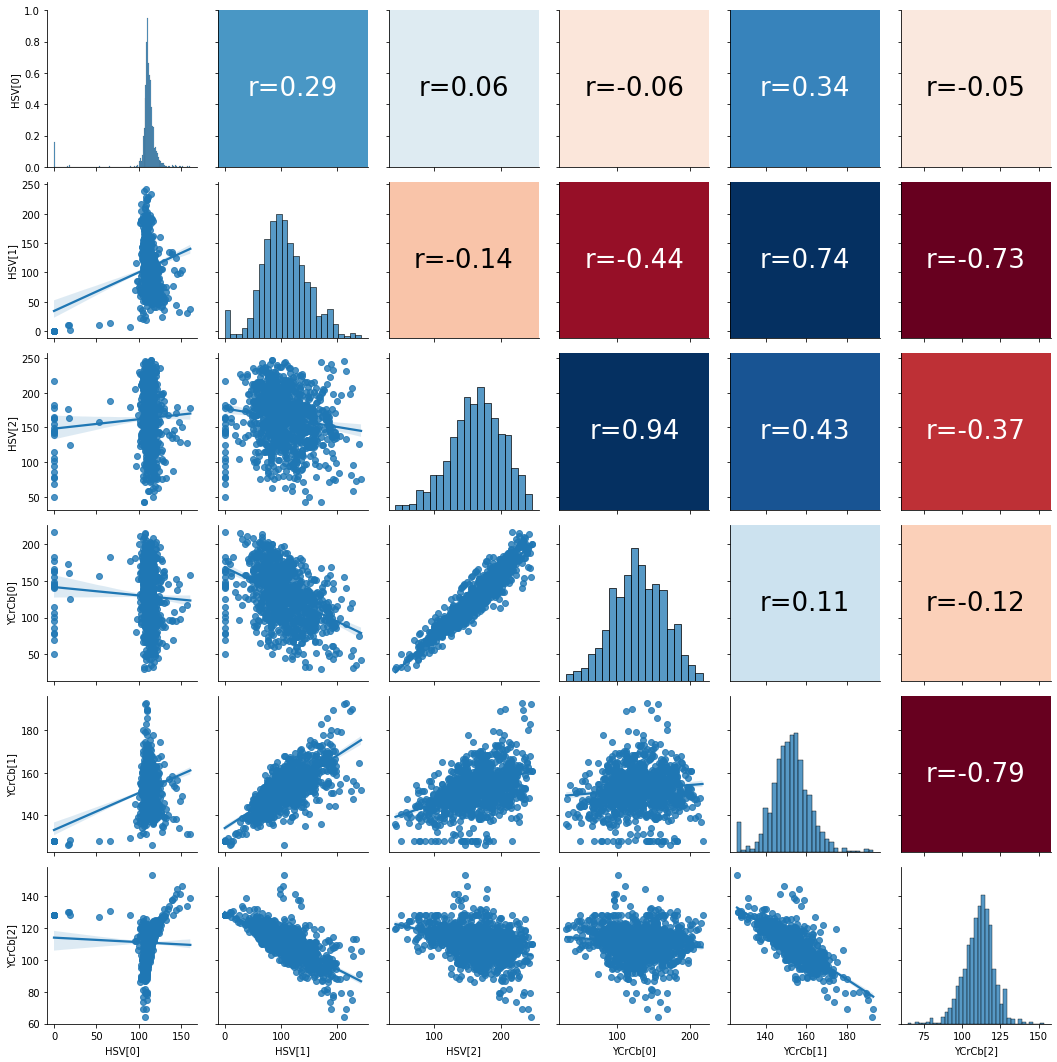

In [44]:
g = sns.PairGrid(df)
g.map_upper(plot_corr)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)

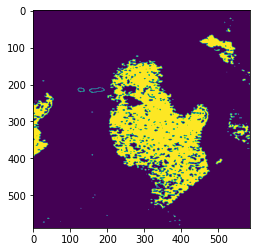

In [28]:
example_img = list(images.keys())[2]
img = images[example_img]['img']
mask = images[example_img]['labels']
mask_one_channel = mask[:,:,0] == 1
img_RGB, img_HSV, img_YCrCb = change_img_to_color_palette(img)
x_y_z = calculate_img_avg_by_channel(img_YCrCb, mask_one_channel)
YCrCb_mask = cv2.inRange(img_YCrCb, (0, int(x_y_z[1])-5, 85), (255,170,135)) 
plt.imshow(YCrCb_mask)

In [29]:
indx = np.where(YCrCb_mask==255)
z = np.zeros((len(indx[0]),2))
z[:,0] = indx[0]
z[:,1] = indx[1]
hull = ConvexHull(z)

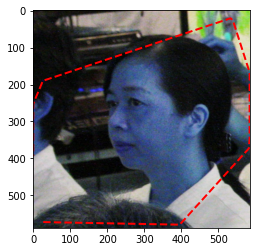

In [30]:
plt.imshow(img)
plt.plot(z[hull.vertices,1], z[hull.vertices,0], 'r--', lw=2)

In [31]:
from skimage.segmentation import mark_boundaries, slic

In [32]:
segments = slic(img_RGB, n_segments = 10, compactness=1,sigma = 3,  start_label = 1)

(-0.5, 585.5, 587.5, -0.5)

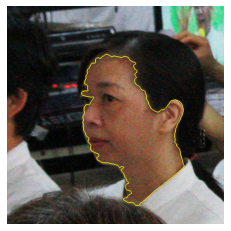

In [33]:
segments = slic(img_YCrCb, n_segments = 3, compactness=1,sigma = 3,  start_label = 1)
img_tmp = mark_boundaries(img_RGB, segments )
plt.imshow(img_tmp) 
plt.axis('off')